In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Домашнее задание №1: визуализация, k-NN регрессия, кросс-валидация.

В этом задании мы рассмотрим задачу прогнозирования количества взятых в аренду велосипедов.

Файл [bike_sharing.csv](https://yadi.sk/d/n8iy_trO3EsUBa) содержит данные о 731 дне работы сервиса по аренде велосипедов. Про каждый день известны:

* instant: record index
* dteday : date
* season : season (1:springer, 2:summer, 3:fall, 4:winter)
* yr : year (0: 2011, 1:2012)
* mnth : month ( 1 to 12)
* holiday : weather day is holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule)
- weekday : day of the week
- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
+ weathersit : 
	- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
	- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
	- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
	- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- temp : Normalized temperature in Celsius from 0 to 100.
- atemp: Normalized feeling temperature in Celsius from 0 to 100.
- hum: Normalized humidity. The values are divided to 100 (max)
- windspeed: Normalized wind speed. The values are divided to 67 (max)
- casual: count of casual users
- registered: count of registered users
- cnt: count of total rental bikes including both casual and registered

**1. (0.25 балла)** Откройте файл bike_sharing.csv, запишите в датафрейм df и выведите первые пять строк датафрейма.

In [2]:
data = pd.read_csv('bike_sharing.csv')
data.head(5)

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,34.4167,36.3625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,36.3478,35.3739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,19.6364,18.9405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,20.0000,21.2122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,22.6957,22.9270,0.436957,0.186900,82,1518,1600


**2. (1 балл)** Постройте график среднего числа арендованных байков (cnt) по каждому месяцу. Не забудьте подписать оси координат. Убедитесь, что в летние месяцы велосипеды в прокат берут чаще.

([<matplotlib.axis.XTick at 0x7fc0c9b32828>,
 <a list of 12 Text xticklabel objects>)

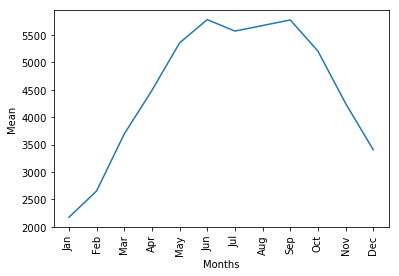

In [3]:
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
x = data['mnth'].unique()
plt.plot(x, data.groupby('mnth')['cnt'].mean())
plt.xlabel('Months')
plt.ylabel('Mean')
plt.xticks(x, months, rotation='vertical')

** 3. (0.5 балла)** Постройте диаграмму рассеяния (scatter plot) с осями cnt и atemp, где точки — это объекты. Какой логичный вывод можно сделать по этому графику?

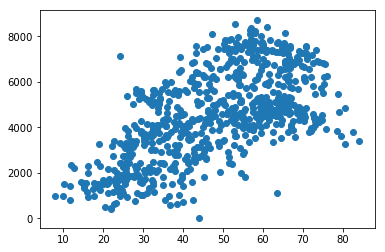

In [4]:
plt.scatter(data['atemp'], data['cnt'])
# when the feeling temperature is higher people rent more bikes

**4. (0.5 балла)** Преобразуйте небинарные категориальные признаки с помощью one-hot кодирования. Сделать это можно с помощью функции pd.get_dummies, указав нужные столбцы в параметре columns. Сколько признаков получилось после кодирования? И какой категориальный признак породил больше всего бинарных?

In [5]:
data = pd.get_dummies(data, columns=['season', 'weathersit', 'mnth', 'weekday'])
# yr, weathersit, workingday are binary features
data.head()

,instant,dteday,yr,holiday,workingday,temp,atemp,hum,windspeed,casual,...,mnth_10,mnth_11,mnth_12,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,1,2011-01-01,0,0,0,34.4167,36.3625,0.805833,0.160446,331,...,0,0,0,0,0,0,0,0,0,1
1,2,2011-01-02,0,0,0,36.3478,35.3739,0.696087,0.248539,131,...,0,0,0,1,0,0,0,0,0,0
2,3,2011-01-03,0,0,1,19.6364,18.9405,0.437273,0.248309,120,...,0,0,0,0,1,0,0,0,0,0
3,4,2011-01-04,0,0,1,20.0000,21.2122,0.590435,0.160296,108,...,0,0,0,0,0,1,0,0,0,0
4,5,2011-01-05,0,0,1,22.6957,22.9270,0.436957,0.186900,82,...,0,0,0,0,0,0,1,0,0,0


In [6]:
#how many features did we get after encoding?
len(data.columns)
#most of new features where generated by 'month' feature (12 months => vector of 12 elements)

38

**5. (0.25 балла)** Удалите столбцы instant, dteday, casual и registered. Предположите, почему мы удаляем эти признаки.

In [7]:
data = data.drop(['instant', 'dteday', 'casual', 'registered'], axis=1)
# instant - !unique! index, which does not affect on prediction
# dteday - we do not need date, because we have name of week day, type of week day (working/weekend/holiday),
# year and so on. Date is not important for predicrions anymore.
# we do not need count of casual and registered users because we have cnt = casual + registered

**6. (0.5 балла)** Далее нашей целевой переменной будет количество арендованных велосипедов (cnt). Поэтому запишите cnt в переменную df_ans и удалите из df. Затем в помощью функции train_test_split из sklearn.model_selection разделите выборку на обучающую и контрольную в отношении 7 к 3, создав переменные X_train, X_test, y_train, y_test.

Замечание 1: установите random_seed, чтобы генератор псевдослучайных чисел работал всегда одинаково.

Замечание 2: если в sklearn.model_selection нет функции train_test_split, обновите scikit-learn.

In [8]:
from sklearn.model_selection import train_test_split
df_ans = data['cnt'].values
data = data.drop('cnt', axis=1) # we can also use inplace=True
X_train, X_test, y_train, y_test = train_test_split(data, df_ans, test_size=0.3, random_state=42)
X_train.head(5)

,yr,holiday,workingday,temp,atemp,hum,windspeed,season_1,season_2,season_3,...,mnth_10,mnth_11,mnth_12,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
223,0,0,1,70.8333,65.4042,0.415000,0.125621,0,0,1,...,0,0,0,0,0,0,0,0,1,0
684,1,0,1,32.1667,32.4492,0.620417,0.152987,0,0,0,...,0,1,0,0,0,0,0,1,0,0
685,1,0,1,34.5000,34.7204,0.524583,0.171025,0,0,0,...,0,1,0,0,0,0,0,0,1,0
163,0,0,1,63.5000,60.1654,0.494583,0.305350,0,1,0,...,0,0,0,0,1,0,0,0,0,0
394,1,0,1,26.9167,26.2625,0.400833,0.215792,1,0,0,...,0,0,0,0,1,0,0,0,0,0


**7. (1 балл)** Обучите алгоритм пяти ближайших соседей с евклидовой метрикой и оцените MAE на контрольной выборке.

In [9]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error
clf = KNeighborsRegressor(n_neighbors=5, metric='euclidean')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
mean_absolute_error(y_test, y_pred)

1069.189090909091

**8. (0.5 балла)** Постройте диаграмму рассеяния (scatter plot), по одной оси отметив настоящее число аренд велосипедов, а по другой — предсказанное алгоритмом. Дополнительно на этом графике постройте прямую $y = x$. Чему соотстветствует отклонение от этой прямой?

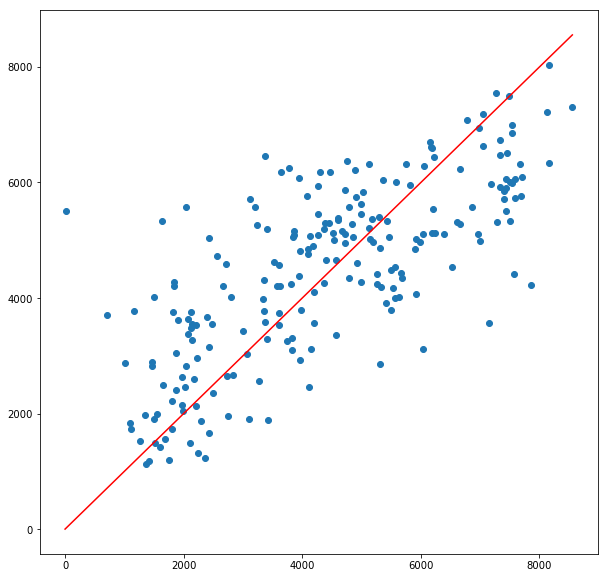

In [10]:
fig1 = plt.figure(figsize=(10,10))
plt.scatter(y_test, y_pred)
plt.plot(np.linspace(0, max(y_test)), np.linspace(0, max(y_test)), 'r')

**9. (1 балл)** Отмасштабируйте признаки, чтобы они принимали значения на $[0, 1]$.

Это можно сделать собственноручно с помощью операций pandas.

Иначе — можно использовать MinMaxScaler из sklearn.preprocessing — класс с методами fit и transform. 
Для этого:

* либо соедините X_train и X_test обратно в единый датафрейм, отмасштабируйте и разъедините обратно,
* либо отмасштабируйте df (без ответов) и разделите на обучающую и контрольную выборку, используя тот же random_seed.

На выходе метода transform получится numpy-массив, который нужно будет превратить обратно в датафрейм.

In [12]:
from sklearn import preprocessing
#data_nm = np.concatenate([X_train, X_test])
data_nm = pd.DataFrame(preprocessing.MinMaxScaler().fit_transform(data))
data_nm.columns = data.columns
X_train, X_test, y_train, y_test = train_test_split(data_nm, df_ans, test_size=0.3, random_state=42)
data_nm.head(5)

,yr,holiday,workingday,temp,atemp,hum,windspeed,season_1,season_2,season_3,...,mnth_10,mnth_11,mnth_12,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0.0,0.0,0.0,0.355170,0.373517,0.828620,0.284606,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.379232,0.360541,0.715771,0.466215,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.171000,0.144830,0.449638,0.465740,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.175530,0.174649,0.607131,0.284297,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.209120,0.197158,0.449313,0.339143,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


**10. (0.5 балла)** Вновь обучите алгоритм пяти ближайших соседей с евклидовой метрикой и оцените MAE на контрольной выборке. Почему качество поменялось?

In [13]:
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
mean_absolute_error(y_test, y_pred)
# in geometric model features which have greater values are intepreted as more important
# however some features could have large values in nature and we should normalize
# all values to avoid mistakes in interpretetion

872.78909090909076

**11. (1.25 балла)** Используя класс KFold из sklearn.model_selection установите с помощью кросс-валидации на пяти фолдах, какой параметр weights лучше с точки зрения mean absolute error. 

In [14]:
def kfold_checker(clf, k, data, df_ans):
    kf=KFold(n_splits=k)
    y_pred = np.zeros(df_ans.shape)
    for train_index, test_index in kf.split(data):
        X_train, X_test = data.values[train_index], data.values[test_index]
        y_train = df_ans[train_index]
        clf.fit(X_train, y_train)
        y_pred[test_index] = clf.predict(X_test)
    print(mean_absolute_error(y_pred, df_ans))
        

from sklearn.model_selection import KFold
print('-------------------uniform--------------------')
clf_uniform = KNeighborsRegressor(n_neighbors=5, metric='euclidean', weights='uniform')
kfold_checker(clf_uniform, 5, data_nm, df_ans)
clf_distance = KNeighborsRegressor(n_neighbors=5, metric='euclidean', weights='distance')
print('-------------------distance-------------------')
kfold_checker(clf_distance, 5, data_nm, df_ans)
#distance is better

-------------------uniform--------------------
1746.26374829
-------------------distance-------------------
1743.65856069


**12. (2.5 балла)** С помощью GridSearchCV из sklearn.model_selection на пяти фолдах выберите лучшее значение $k$ от 1 до 50. Постройте график MAE на кросс-валидации в зависимости от $k$. 

Замечание: Передать нужную метрику качества для GridSearchCV можно через параметр scoring, но не всё так просто. Из метрики качества нужно сделать «scorer» c помощью функции sklearn.metrics.make_scorer, не забыв указать нужное значение greater_is_better.

In [17]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
scorer = make_scorer(mean_absolute_error, greater_is_better=False)
clf.get_params().keys()

dict_keys(['algorithm', 'weights', 'leaf_size', 'metric', 'n_neighbors', 'p', 'metric_params', 'n_jobs'])

In [18]:
gsv = GridSearchCV(clf, param_grid={'n_neighbors': np.arange(1, 51), 'weights': ['distance', 'uniform']}, scoring=scorer, cv=5)
gsv.fit(data_nm, df_ans)

GridSearchCV(cv=5, error_score='raise',
       estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='euclidean',
          metric_params=None, n_jobs=1, n_neighbors=5, p=2,
          weights='uniform'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'weights': ['distance', 'uniform'], 'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(mean_absolute_error, greater_is_better=False),
       verbose=0)

In [20]:
gsv.best_params_

{'n_neighbors': 46, 'weights': 'uniform'}

/home/bobrg/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['xkcd', 'Humor Sans', 'Comic Sans MS'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


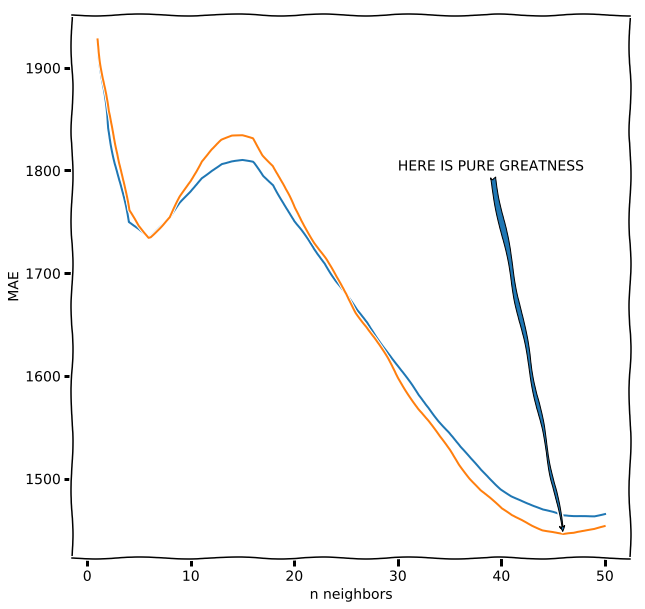

In [111]:
fig = plt.figure(figsize=(10,10))
plt.xkcd()
ax = fig.add_subplot(1, 1, 1)
xx = np.array(gsv.cv_results_['param_n_neighbors'])
yy = gsv.cv_results_['mean_test_score']

plt.xlabel('n neighbors')
plt.ylabel('MAE')

plt.plot(xx[::2], yy[::2]*-1)
plt.plot(xx[1::2], yy[1::2]*-1)

plt.annotate(
    'HERE IS PURE GREATNESS',
    xy=(46, 1446.42773),arrowprops=dict(arrowstyle='fancy'), xytext=(30, 1800))

**13. (0.25 балла)** Посчитайте качество итоговой модели на контрольной выборке. 